## 음성 데이터 전처리

반려동물은 인간이 이해할 수 있는 '언어'를 통해 소통하지 않으나 원하는 바에 따라 각 울음소리의 성조, 진폭, 등의 특징적인 차이가 있을 것이며 이에 따른 패턴의 차이가 존재할 것이라고 가설을 설정하였다.

가설을 검증한 뒤 각 상태(hunger, isolation, ...etc)에 따른 특징점을 찾아내기 위해 데이터를 전처리하는 과정을 소규모의 데이터셋에 대해 시각적으로 보여준다.

1. sample rate를 16000으로 통일한다.

2. 로그 멜 스펙트럼을 통해 음성의 파워를 측정한다.

3. 파워의 지역 최솟값을 기준으로 음성을 분할한다.

4. 분할된 음성의 앞뒤 화이트 노이즈(특정 임계값 이하의 에너지를 가지는 시점)을 제거한다.

5. 분할된 음성이 노이즈를 제거하여 패턴을 보다 잘 드러나게 한다.

6. 음성 정규화를 수행한다.

7. Padding과 Trimming을 통해 평균 세그멘테이션 길이를 가지도록 음성의 길이를 통일한다.

8. 음성의 유사도를 측정하여 하위 10%의 데이터는 제외한다.

9. 유사도 상위 10% 데이터에 대하여 SpecAugment를 적용하여 Training 데이터에 대해 마스킹 작업을 수행한다. 각 파일 당 마스킹 파일 2개를 생성한다.


In [1]:
# Load packages
import os
import sys
import wave
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

In [31]:
target_animal = 'dog'  # 'cat', 'dog'
target_state = 'hostile'
target_file_name = 'dog8.wav'

# Set Path
main_path = os.path.join(os.getcwd().rsplit(
    'FurEmotion-AI')[0], 'FurEmotion-AI')
data_path = os.path.join(main_path, 'data', target_animal)
temp_data_path = os.path.join(main_path, 'temp_data', target_animal)
csv_path = os.path.join(main_path, 'origin_data_info.csv')
origin_data_path = os.path.join(main_path, 'origin_data', target_animal)

sys.path.append(main_path)

# set target file
origin_file_path = os.path.join(
    origin_data_path, target_state, target_file_name)
resampling_origin_file_dir = os.path.join(main_path, '_temp')
resampling_origin_file_path = os.path.join(
    resampling_origin_file_dir, target_file_name)
if not os.path.exists(resampling_origin_file_dir):
    os.makedirs(resampling_origin_file_dir, exist_ok=True)


print('origin_file_path:', origin_file_path)

origin_file_path: /Users/jaewone/Downloads/FurEmotion-AI/origin_data/dog/hostile/dog8.wav


### 음성의 파워 그래프를 통한 세그먼트 추출

반려동물이 '언어'적 소통을 하는 것은 아니나 원하는 바가 있을 경우 '강하게' 표출할 것이라 생각한다. 또한 원하는 바를 '강하게' 표출할 것이기에 상태(hunger, isolation, ...etc)에 따른 진폭과 주파수에 따른 패턴이 잘 드러날 것으로 예상한다.

따라서 위 가설을 검증하고자 음성의 파워(성조의 세기) 그래프를 그린 뒤 파워가 강한 부분의 세그먼트를 추출, 분석하여 음성의 패턴이 잘 드러나는지 확인한다.


#### 1. wav 파일을 sample rate 16000으로 불러온다


In [3]:
import sox
from tqdm import tqdm


def resampling(file_path_list: list[str], output_path: str, target_sample_rate: int = 16000):
    """
    Change sample rate

    Before start:

        sox를 설치하여야 아래 함수를 수행할 수 있다.

        OS X: brew install sox

        linux: apt-get install sox

        windows: exe 파일을 다운받아 실행: https://sourceforge.net/projects/sox/files/sox/14.4.1/

    Parameters:
        file_path_list: 변환하고자 하는 wav 파일 리스트

        output_path: 변환된 결과물을 저장하고자 하는 폴더 경로.

        target_sample_rate: 변환하고자 하는 sample rate

    Returns: None
    """
    tfm = sox.Transformer()
    tfm.convert(samplerate=target_sample_rate)

    for i in tqdm(range(len(file_path_list))):
        if not os.path.exists(file_path_list[i]):
            raise OSError(f'File {file_path_list[i]} not exist')

        file = file_path_list[i].rsplit('/', 1)[1]
        output_file_path = os.path.join(output_path, file)

        try:
            tfm.build(file_path_list[i], output_file_path)
        except:
            print(f'Error in {file_path_list[i]}')
            continue


# Read Wav
def read_wav(file_path):
    with wave.open(file_path, 'r') as wav_file:
        n_channels, sampwidth, framerate, n_frames, comptype, compname = wav_file.getparams()
        audio_data = wav_file.readframes(n_frames)
        audio_data = np.frombuffer(audio_data, dtype=np.int16)

    # Stereo 파일의 경우 mono로 변환
    if n_channels == 2:
        audio_data = (audio_data[::2] + audio_data[1::2]) / 2

    return [audio_data, {'n_channels': n_channels,
                         'sampwidth': sampwidth,
                         'framerate': framerate,
                         'n_frames': n_frames,
                         'comptype': comptype,
                         'compname': compname}]


# resampling
resampling(
    file_path_list=[origin_file_path],
    output_path=resampling_origin_file_dir,
    target_sample_rate=16000
)


# read wav file
audio_data, audio_status = read_wav(resampling_origin_file_path)
print(f'file: {resampling_origin_file_path}')
for status in audio_status:
    print(f'{status} : {audio_status[status]}')

100%|██████████| 1/1 [00:00<00:00, 37.89it/s]

file: /Users/jaewone/Downloads/FurEmotion-AI/_temp/dog8.wav
n_channels : 1
sampwidth : 2
framerate : 16000
n_frames : 64000
comptype : NONE
compname : not compressed


#### 음성의 파워 그래프를 그린다.


(40, 64)


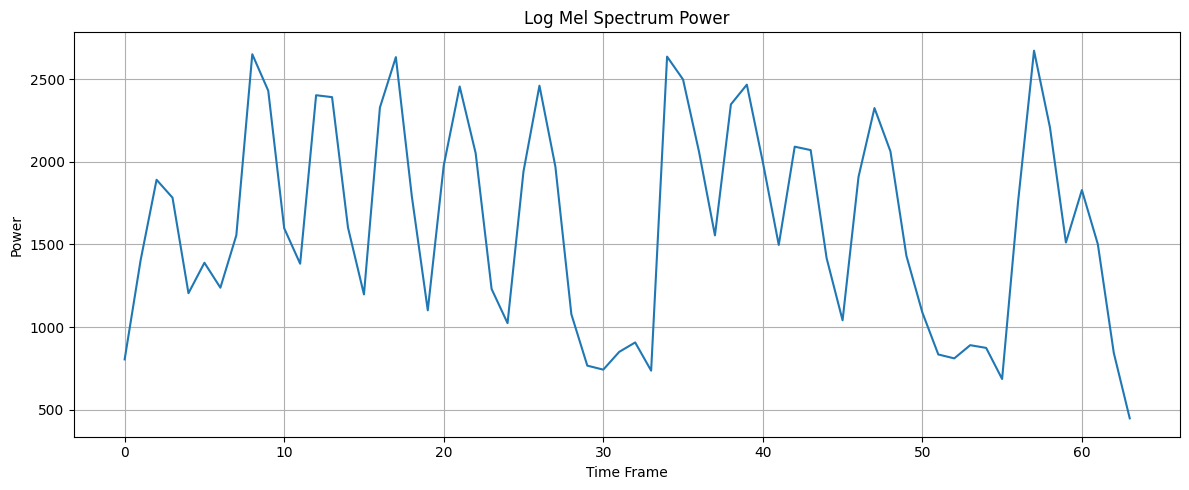

In [4]:
from scipy.signal import stft


def mel_filter_bank(num_filters, fft_size, sample_rate):
    """
    멜 필터뱅크 생성
    """
    # 멜 스케일과 헤르츠 스케일 간의 변환 함수
    def hz_to_mel(hz): return 2595 * np.log10(1 + hz / 700)
    def mel_to_hz(mel): return 700 * (10**(mel / 2595) - 1)

    # 멜 스케일로 끝점 설정
    mel_end = hz_to_mel(sample_rate / 2)
    mel_points = np.linspace(hz_to_mel(0), mel_end, num_filters + 2)
    hz_points = mel_to_hz(mel_points)

    # FFT 주파수 인덱스로 변환
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)

    # 필터뱅크 생성
    filters = np.zeros((num_filters, fft_size // 2 + 1))
    for i in range(1, num_filters + 1):
        filters[i - 1, bin_points[i - 1]:bin_points[i]] = \
            (np.arange(bin_points[i - 1], bin_points[i]) -
             bin_points[i - 1]) / (bin_points[i] - bin_points[i - 1])
        filters[i - 1, bin_points[i]:bin_points[i + 1]] = 1 - \
            (np.arange(bin_points[i], bin_points[i + 1]) -
             bin_points[i]) / (bin_points[i + 1] - bin_points[i])
    return filters


def get_log_mel_spectogram(audio_data, framerate, num_filters=40, nperseg=2048, noverlap=1024, nfft=2048):
    # STFT 계산
    _, _, Zxx = stft(audio_data, fs=framerate, nperseg=nperseg,
                     noverlap=noverlap, nfft=nfft)
    magnitude = np.abs(Zxx)

    # 로그 멜 스펙트럼 추출
    num_filters = num_filters
    filters = mel_filter_bank(num_filters, 2048, framerate)
    mel_spectrum = np.dot(filters, magnitude)
    log_mel_spectrum = np.log(mel_spectrum + 1e-9)  # log 0을 피하기 위한 작은 값 추가
    return log_mel_spectrum


def get_mel_power(log_mel_spectrum):
    # 로그 멜 스펙트럼의 파워 계산
    return np.sum(log_mel_spectrum**2, axis=0)


def show_mel_power(power, dot_list=[], dot_color='red', dot_label=''):
    # 파워 시각화
    plt.figure(figsize=(12, 5))
    plt.plot(power)
    plt.title("Log Mel Spectrum Power")
    plt.xlabel("Time Frame")
    plt.ylabel("Power")

    if (len(dot_list) > 0):
        plt.scatter(dot_list, power[dot_list],
                    color=dot_color, label=dot_label)
        plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()


log_mel_spectrum = get_log_mel_spectogram(
    audio_data, audio_status['framerate'])
print(log_mel_spectrum.shape)
power = get_mel_power(log_mel_spectrum)
show_mel_power(power)

#### 파워 최솟값 구하기

파워가 강한 범위의 음성을 추출하기 위해 파워가 가장 작은 지점 n개를 구한다.

파워가 가장 작은 지점을 기준으로 음성을 분할하여 세그먼트를 추출하고자 한다.


[63, 55, 33, 30]


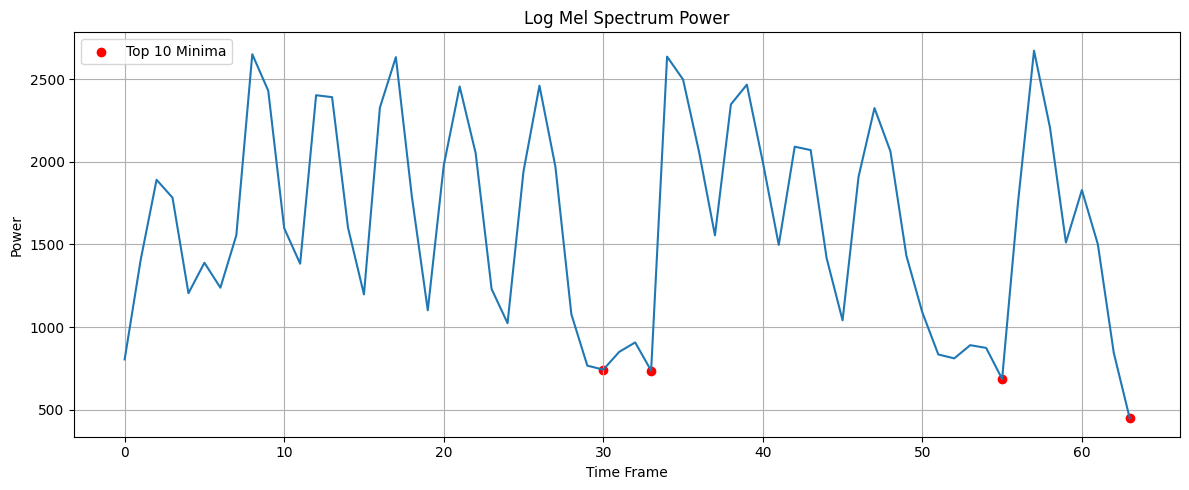

In [5]:
def minima_points(power_array, n):
    """
    주어진 파워 배열에서 최솟값이 되는 n개의 시점을 반환하는 함수.

    Parameters:
    - power_array: 파워 배열
    - n: 반환할 최솟값의 개수

    Returns:
    - min_indices: 최솟값이 되는 n개의 시점의 리스트
    """
    return np.argsort(power_array)[:n].tolist()


# 파워에서 최솟값 4개 찾기
min_indices = minima_points(power, 4)
print(min_indices)

show_mel_power(power, dot_list=min_indices, dot_label='Top 10 Minima')

위와 같이 전체 범위에 대하여 파워가 최소가 되는 n개의 지점을 구하면 음성의 앞과 뒤부분의 골짜기(급격히 파워가 감소하는 부분)에 대부분의 최소점이 몰리게 되는 문제가 발생한다.

이에 k초당 하나의 최솟값(최소가 되는 지점)을 찾음을 통해 위 문제를 해결하였다.

예를 들어 전체 음성의 길이가 6초이며 k를 2로 설정한 다면 0~2초, 2~4초, 4~6초로 총 3개의 지역 최솟값을 구한다.

<br>

본 연구에서 적절한 k값으로 3초를 설정하였다.

이는 음성의 평균값에 기반하여 설정되었다.


[np.int64(29), np.int64(55), np.int64(63)]


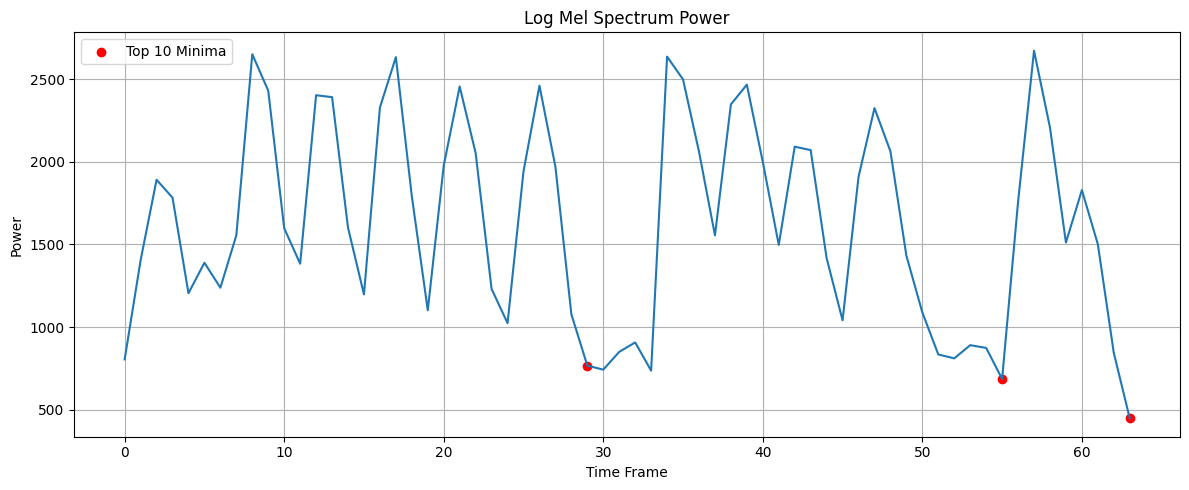

In [6]:
def get_interval_min_sec(power, sec: int = 1):
    interval_sec = int(10 * sec)
    min_sec_list = []
    for i in range(0, len(power) + 1, interval_sec):
        min_sec = i + np.argsort(power[i:i + interval_sec])[0]
        min_sec_list.append(min_sec)
    return min_sec_list


search_in_sec = 3
min_sec_list = get_interval_min_sec(power, sec=search_in_sec)

print(min_sec_list)
show_mel_power(power, dot_list=min_sec_list, dot_label='Top 10 Minima')

위의 파워 그래프에서 붉은색 점은 일정 구간 내의 지역 파워 최솟값이다. 최솟값을 기준으로 음성을 분할하여 세그먼트를 생성한다.


In [7]:
def split_audio_on_indices(audio_data, power, indices):
    """
    주어진 인덱스를 기준으로 오디오 데이터를 여러 부분으로 나누는 함수.

    Parameters:
    - audio_data: 오디오 데이터 배열
    - indices: 분할할 시점의 리스트

    Returns:
    - audio_segments: 나눈 오디오 데이터의 리스트
    """
    # STFT를 통해 구한 시점을 오디오 샘플의 시점으로 변환
    nperseg = 2048
    noverlap = 1024
    samples_per_frame = (len(audio_data) - nperseg) / (len(power) - 1)
    sample_indices = [int(index * samples_per_frame) for index in indices]

    audio_segments = []
    prev_index = 0
    for index in sample_indices:
        segment = audio_data[prev_index:index]
        if len(segment) != 0:
            audio_segments.append(segment)
        prev_index = index
    audio_segments.append(audio_data[prev_index:])  # 마지막 세그먼트 추가

    return audio_segments


audio_segments_sec = split_audio_on_indices(audio_data, power, min_sec_list)


# 각 세그먼트의 길이 확인
segment_lengths = [len(segment) for segment in audio_segments_sec]
segment_lengths

[28517, 25568, 7867, 2048]

생성된 세그먼트를 각각의 wav 파일로 저장한다.


In [8]:
from uuid import uuid4


def save_audio_segments_as_wav(audio_segments, output_dir, prefix, sampwidth, framerate):
    """
    주어진 오디오 세그먼트들을 WAV 파일로 저장하는 함수.

    Parameters:
    - audio_segments: 나눈 오디오 데이터의 리스트
    - output_dir: 출력 디렉토리 경로
    - prefix: 저장할 파일의 접두사

    Returns:
    - filepaths: 저장된 파일의 경로 리스트
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    filepaths = []
    for i, segment in enumerate(audio_segments):
        filename = f"{prefix}_{uuid4()}.wav"
        filepath = os.path.join(output_dir, filename)
        with wave.open(filepath, 'wb') as wav_file:
            wav_file.setnchannels(1)
            wav_file.setsampwidth(sampwidth)
            wav_file.setframerate(framerate)
            wav_file.writeframes(segment.tobytes())
        filepaths.append(filepath)

    return filepaths


# 오디오 세그먼트를 WAV 파일로 저장
output_dir = os.path.join(main_path, 'visual_test')
saved_filepaths = save_audio_segments_as_wav(
    audio_segments=audio_segments_sec,
    output_dir=output_dir,
    prefix=resampling_origin_file_path.rsplit(
        '/', 1)[1].rsplit('.')[0],  # file name
    sampwidth=audio_status['sampwidth'],
    framerate=audio_status['framerate'],
)

위에서 아래와 같이 가설을 설정하였었다.

**반려동물이 '언어'적 소통을 하는 것은 아니나 원하는 바가 있을 경우 '강하게' 표출하며 상태(hunger, isolation, ...etc)에 따른 진폭과 주파수에 따른 패턴이 잘 드러날 것이다.**

위 가설을 검증하고자 각각의 세그먼트의 멜 스펙트럼을 확인하여 음성의 주파수와 진폭에 따른 패턴이 잘 드러나는지 확인한다.

> 패턴을 더 명확하게 확인하기 위하여 각 세그먼트의 노이즈를 제거한다. 만약 세그먼트의 앞뒤에 화이트 노이즈가 존재할 경우 제거하여 음성의 길이를 줄인다.


/Users/jaewone/ENTER/envs/tf24/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


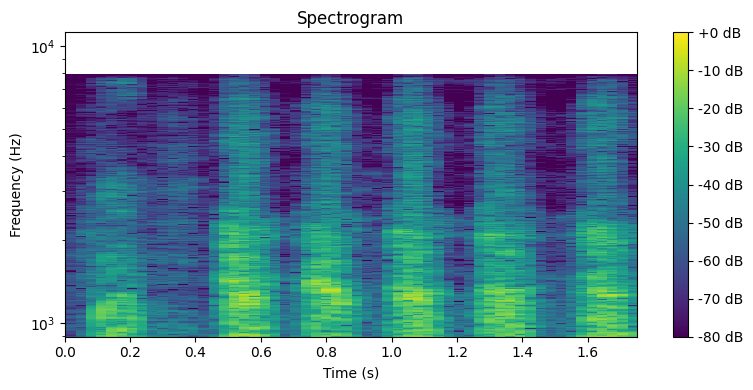

Duration of the audio file: 1.78 -> 1.71


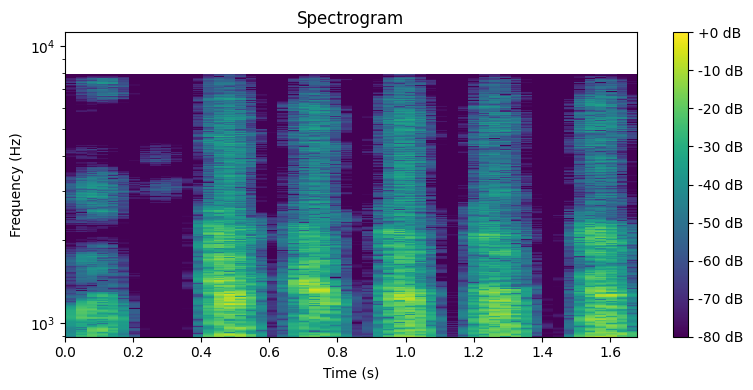

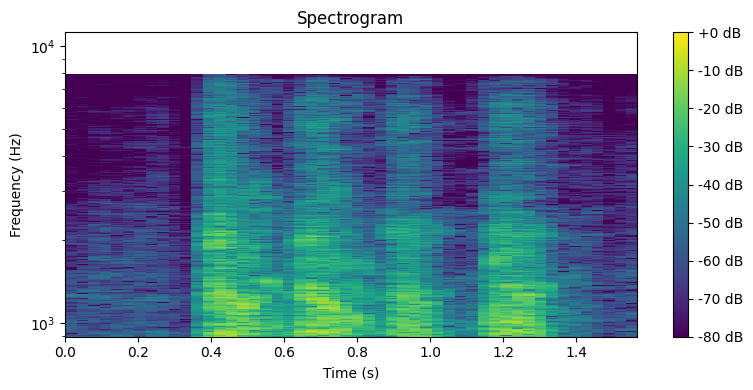

Duration of the audio file: 1.60 -> 1.07


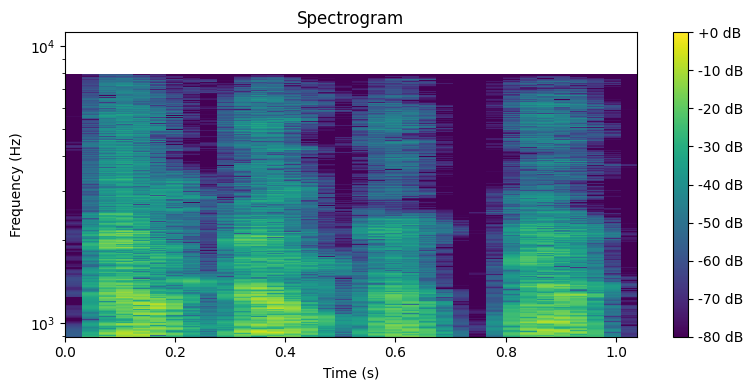

In [9]:
from typing import Optional
from scipy.io import wavfile
import noisereduce as nr
import wave
import numpy as np

from utils.os import *
from utils.sound import *


def reduced_base_noise(file_path: str,
                       output_path: Optional[str] = None,
                       inplace: bool = False):
    """
    noisereduce 라이브러리를 이용하여 기본적인 노이즈를 감소시킨다.

    Parameters:
        * file_path : 처리하고자 하는 파일의 경로
        * output_path : 처리한 결과를 저장하고자 하는 파일 경로. 없을 경우 file_path의 파일을 덮어쓴다.
        * inplace : 원본 데이터(file_path)를 처리한 파일로 덮어쓴다.

    Returns: None
    """

    if inplace == False and output_path == None:
        raise ValueError(f'output path must be defined if inplace is False.')

    if output_path == None or inplace == True:
        output_path = file_path

    # load data
    rate, data = wavfile.read(file_path)

    # perform noise reduction
    reduced_noise = nr.reduce_noise(y=data, sr=rate)
    wavfile.write(output_path, rate, reduced_noise)


def detect_non_silence(audio_data: np.ndarray, threshold: float, frame_size: int) -> list[int]:
    """
    오디오 신호에서 무음이 아닌 섹션의 시작과 끝을 감지한다.

    Parameters:
        - audio_data (numpy.ndarray): 묵음을 감지해야 하는 오디오 데이터.
        - threshold (float): 오디오가 무음으로 간주되는 에너지 임계값.
        - frame_size (int): 오디오 에너지의 이동 평균을 계산하기 위해 고려할 샘플 수.

    Returns:
        - start (int): 비침묵 섹션의 시작 샘플.
        - end (int): non-silence 섹션의 엔딩 샘플.
    """

    moving_avg = np.convolve(audio_data, np.ones(
        (frame_size,)) / frame_size, mode='valid')
    non_silence = np.where(moving_avg > threshold)[0]

    start = non_silence[0]
    # compensate for the 'valid' mode in convolution
    end = non_silence[-1] + frame_size

    return start, end


def trim_audio(file_path: str, output_path: Optional[str] = None, inplace: bool = False, frame_size=5000):
    """
    오디오의 앞뒤에 존재하는 화이트 노이즈를 제거한다.
    화이트 노이즈는 음성의 전체 에너지의 하위 10%에 해당하는 시점으로 정의한다.

    Parameters:
        * file_path : 처리하고자 하는 파일의 경로
        * output_path : 처리한 결과를 저장하고자 하는 파일 경로. 없을 경우 file_path의 파일을 덮어쓴다.
        * inplace : 원본 데이터(file_path)를 처리한 파일로 덮어쓴다.

    Returns: None
    """

    if inplace == False and output_path == None:
        raise ValueError(f'output path must be defined if inplace is False.')

    # wav 파일을 읽어온다.
    with wave.open(file_path, "r") as file:
        params = file.getparams()
        n_frames = params[3]
        audio_data = file.readframes(n_frames)
        wave_data = np.frombuffer(audio_data, dtype=np.int16)

    # 오디오 시그널을 통한 에너지 계산
    energy = np.abs(wave_data)

    # 백색 잡음을 분류하기 위한 임계값을 설정.
    # 전체 에너지의 하위 10%에 10을 곱하여 임계값을 설정하였으나 추가적은 고민이 필요하다.
    threshold = np.percentile(energy, 10) * 10

    # Use a larger frame size to get a moving average of the audio energy
    frame_size = frame_size
    error_files = []
    try:
        start, end = detect_non_silence(energy, threshold, frame_size)
        trimmed_wave_data = wave_data[start:end]
    except:
        trimmed_wave_data = wave_data
        error_files.append(file_path)
    # print(start, end)

    # trim된 numpy array를 wav 파일로 저장한다.
    if inplace or output_path == None:
        remove_file(file_path)
        output_path = file_path
    with wave.open(output_path, "w") as out_file:
        out_file.setparams(params)
        out_file.writeframes(trimmed_wave_data.tobytes())

    return error_files


def show_spectrum(y, sr):
    # STFT 계산
    D = librosa.amplitude_to_db(abs(librosa.stft(y)), ref=np.max)

    # 시간과 주파수 축을 위한 값들 계산
    times = np.linspace(0, len(y) / sr, num=D.shape[1], endpoint=False)
    freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)

    # 스펙트럼 시각화
    plt.figure(figsize=(8, 4))
    plt.imshow(D, aspect='auto', origin='lower', extent=[
               times.min(), times.max(), freqs.min(), freqs.max()])
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()


target_files = []

for file_path in saved_filepaths:
    # WAV 파일 로드
    y, sr = librosa.load(file_path, sr=None)

    # 파일의 길이(초) 출력
    origin_duration = librosa.get_duration(y=y, sr=sr)
    if origin_duration > search_in_sec / 2:
        target_files.append(file_path)
        show_spectrum(y, sr)
        trim_audio(file_path, inplace=True, frame_size=1000)
        reduced_base_noise(file_path, inplace=True)

        y, sr = librosa.load(file_path, sr=None)
        duration = librosa.get_duration(y=y, sr=sr)
        print(
            f"Duration of the audio file: {origin_duration:.2f} -> {duration:.2f}")
        show_spectrum(y, sr)

위는 각 세그먼트의 멜 스펙트럼이며 아래는 전체 음성에 대한 멜 스펙트럼이다.

전체 음성 중 주파수와 진폭에 따른 패턴이 명확하게 보이는 부분은 위 세그먼트 멜 스펙트럼에서 확인할 수 있다.

따라서 **반려동물이 '언어'적 소통을 하는 것은 아니나 원하는 바가 있을 경우 '강하게' 표출하며 상태(hunger, isolation, ...etc)에 따른 진폭과 주파수에 따른 패턴이 잘 드러날 것이다**라는 가설을 검증할 수 있다.


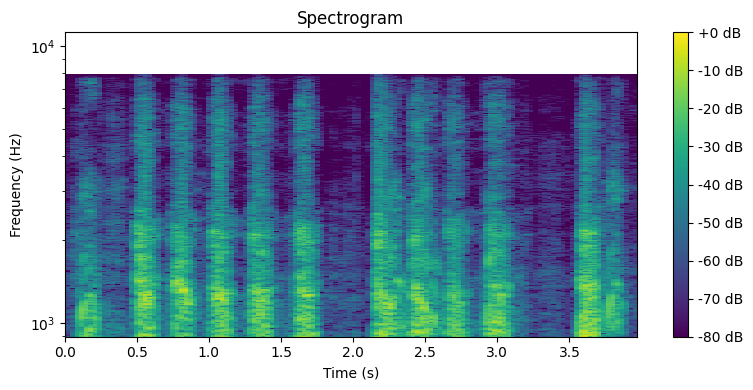

Duration of the audio file: 4.00 seconds


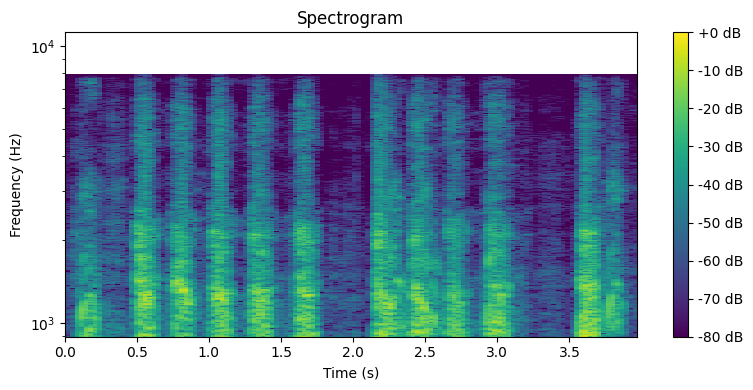

In [10]:
# 전체 음성의 멜 스펙트럼

# WAV 파일 로드
y, sr = librosa.load(resampling_origin_file_path, sr=None)
show_spectrum(y, sr)

# 파일의 길이(초) 출력
duration = librosa.get_duration(y=y, sr=sr)
if duration > 1:
    print(f"Duration of the audio file: {duration:.2f} seconds")

    show_spectrum(y, sr)

음성의 특징이 잘 드러나는 세그먼트를 위 과정을 통하여 추출하였다.

세그먼트들을 이용하여 상태(hunger, isolation, ...etc)를 분류하는 모델을 생성하기 위해 Padding과 Trimming을 통해 동일한 크기의 벡터(sample rate는 16000Hz로 통일되어 있으니 음성의 길이를 통일하여 동일한 크기의 벡터를 구성한다)를 구성한다.

<br>

음성의 길이는 전체 세그먼트 길이의 평균을 사용할 것이나 본 문서에서는 데이터의 일부만을 사용하여 진행하였기에 세그먼트 길이의 평균을 알지 못한다.

이에 본 문서에서는 음성의 길이를 임의로 2초로 설정하였다.

<br>

Padding과 Trimming을 통해 2초로 통일된 음성을 아래 멜 스펙트럼을 통해 확인할 수 있다.


/Users/jaewone/Downloads/FurEmotion-AI/visual_test/sec_test_result/dog8_f5d73c8e-0082-4b3f-a05b-6d694bb8e32a.wav


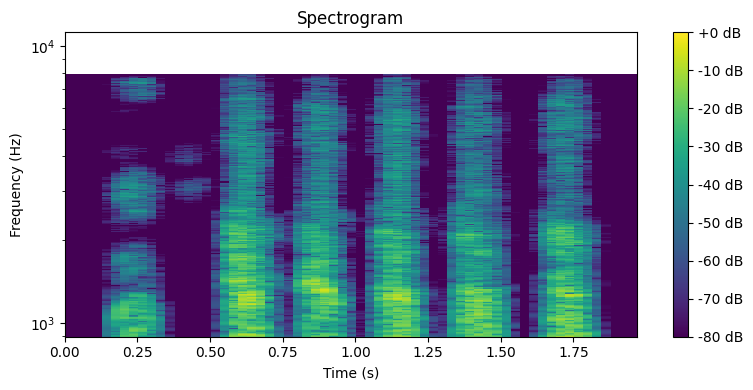

/Users/jaewone/Downloads/FurEmotion-AI/visual_test/sec_test_result/dog8_1256adfd-417e-4340-8493-25683bb4388d.wav


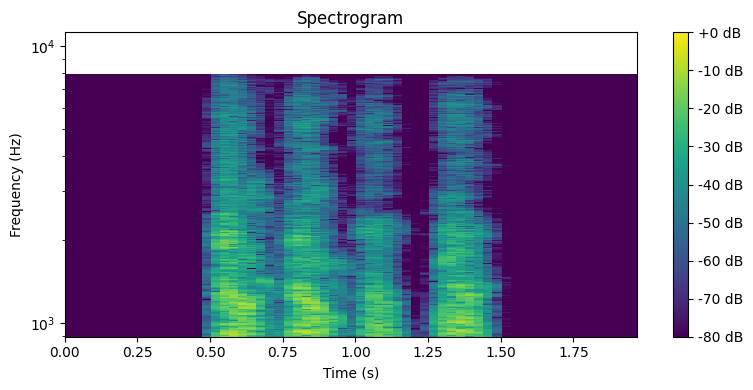

In [11]:
def pad_audio_to_length(input_path, output_path, target_duration):
    """
    wav 파일을 target_duration 길이로 맞춘다. 
    음성의 중심을 기준으로 target_duration보다 짧을 경우 앞뒤에 Padding을 추가하며 
    음성의 중심을 기준으로 target_duration보다 길 경우 앞뒤를 자른다.
    """
    # WAV 파일 읽기
    y, sr = librosa.load(input_path, sr=None)

    # 현재 오디오 파일의 길이 확인
    current_duration = len(y) / sr

    # target_duration과 비교하여 패딩 또는 trimming 필요 여부 확인
    total_samples = int(target_duration * sr)

    if len(y) < total_samples:
        # 패딩 필요
        padding_samples = total_samples - len(y)
        left_padding = padding_samples // 2
        right_padding = padding_samples - left_padding
        processed_audio = np.pad(
            y, (left_padding, right_padding), mode='constant')
    else:
        # trimming 필요
        excess_samples = len(y) - total_samples
        left_trim = excess_samples // 2
        right_trim = excess_samples - left_trim
        processed_audio = y[left_trim:-right_trim]

    # 변환된 데이터를 WAV 파일로 저장
    sf.write(output_path, processed_audio, sr)

    return output_path


output_dir = os.path.join(main_path, 'visual_test', 'sec_test_result')
if not (os.path.exists(output_dir)):
    os.mkdir(output_dir)

for file_path in target_files:
    output_path = os.path.join(output_dir, file_path.rsplit('/', 1)[1])
    pad_audio_to_length(file_path, output_path, search_in_sec - 1)
    print(output_path)
    y, sr = librosa.load(output_path, sr=None)
    show_spectrum(y, sr)

데이터 증강을 수행하기 위해 각 상태의 특징이 가장 두드러지는 10%의 음성에 대해 마스킹을 진행 할 것이다.

각 상태의 특징이 가장 두드러지는 음성을 찾기 위해 유사도 분석을 수행 할 것이다. 하지만 본 문서는 전체 데이터가 아닌 일부 데이터만을 사용하였기에 유사도 분석은 생략한 뒤 마스킹 작업을 수행 할 것이다.

아래는 마스킹 작업을 수행한 음성의 멜 스펙트럼이다.


(128, 63)


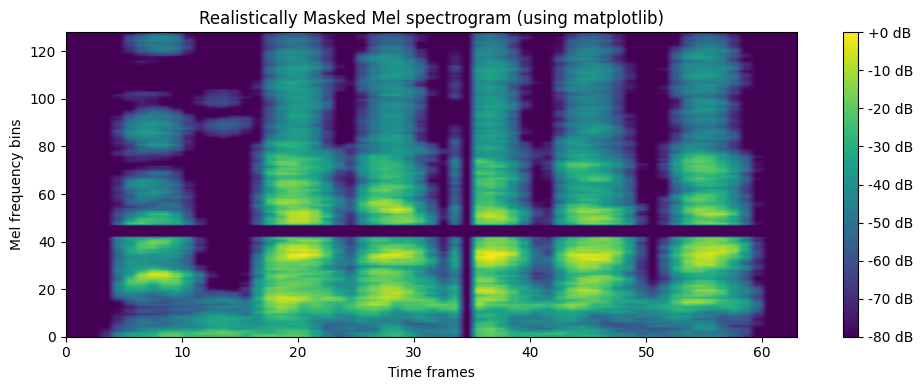

In [29]:
def mask_melspectrogram(file_path,
                        freq_mask_num=2,
                        time_mask_num=2,
                        freq_masking_max_percentage=0.15,
                        time_masking_max_percentage=0.3):

    # 1. Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # 2. Extract mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)

    num_freq_bins = mel_spectrogram.shape[0]
    num_time_bins = mel_spectrogram.shape[1]

    # 3. Apply masking
    # Frequency masking
    for _ in range(freq_mask_num):
        freq_start = np.random.randint(0, num_freq_bins)
        freq_length = np.random.randint(
            0, int(num_freq_bins * freq_masking_max_percentage))
        freq_end = min(mel_spectrogram.shape[0], freq_start + freq_length)
        mel_spectrogram[freq_start:freq_end, :] = 0

    # Time masking
    for _ in range(time_mask_num):
        time_start = np.random.randint(0, num_time_bins)
        time_length = np.random.randint(
            0, int(num_time_bins * time_masking_max_percentage))
        time_end = min(mel_spectrogram.shape[1], time_start + time_length)
        mel_spectrogram[:, time_start:time_end] = 0

    return mel_spectrogram


def show_masked_mel(db_masked_mel):
    plt.figure(figsize=(10, 4))
    plt.imshow(db_masked_mel, origin='lower', aspect='auto',
               extent=[0, db_masked_mel.shape[1], 0, db_masked_mel.shape[0]])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Realistically Masked Mel spectrogram (using matplotlib)')
    plt.xlabel('Time frames')
    plt.ylabel('Mel frequency bins')
    plt.tight_layout()
    plt.show()


# Extract and mask the melspectrogram
masked_mel_spectrogram_realistic = mask_melspectrogram(
    os.path.join(output_dir, [file for file in os.listdir(
        output_dir) if file.endswith('.wav')][-1]),
    freq_mask_num=1,
    time_mask_num=1,
    freq_masking_max_percentage=0.15,
    time_masking_max_percentage=0.1
)

# Convert the mel spectrogram to decibels for visualization
db_masked_mel = librosa.power_to_db(
    masked_mel_spectrogram_realistic, ref=np.max)

print(db_masked_mel.shape)

show_masked_mel(db_masked_mel)

In [30]:
from utils.os import remove_path_with_files

remove_path_with_files(output_dir)
remove_path_with_files(resampling_origin_file_dir)